`WUR Machine Learning Course - Assignment 2 - Version 2025`

# Project Report
Throughout this notebook, you will find Tasks T that describe what you need to implement/produce and Questions Q that need to be answered in the report. Please submit a PDF report of your progress to Brightspace. Note, the report can also be a PDF export of this notebook or a separate report using word or latex. In that case, also attach the notebook to show the source code.

# GenAI Policy
We designed this notebook with GenAI in mind. The implementation tasks are challenging and we don't provide support code, so use it in your implementation through the built-in tool in Google Colab or via ChatGPT, GHCopilot, etc. Do not use GenAI to answer the questions (it won't help). Please add a short AI statement at the end of your report where you outline to what extent you used GenAI.

# Regional crop yield prediction
Welcome to the second project in the MGI track of the course. In this exercise, we investigate the problem of regional crop
yield prediction.
Crop yield prediction is an important but complex problem,
as crop yield forecasts are valuable to several stakeholders in the agrifood chain.
Crop yield is influenced by environmental conditions, agricultural management decisions, and many crop-specific parameters.


It is difficult to build a reliable and explainable forecasting model, especially at a regional scale.
More about using machine learning for regional crop forecasting see the work of [*Paudel et al.* (2021)](http://dx.doi.org/10.1016/j.agsy.2020.103016).


In this assignment, you will employ **regression models** to forecast early season crop yields for all Dutch provinces. To predict regional crop yields you will use spatio-temporal  [open data](https://zenodo.org/record/4312941) from the European Commission’s Joint Research Center (JRC). Data cover all 11 Dutch provinces.


Your task is to predict crop yields for potato using machine learning models that you have learned about in the lectures. In the process, you will investigate which features contribute the most to the prediction models and which algorithm performs better!

## Data description

The original data have been preprocessed to obtain features (or predictor variables) and labels (or target variables).
Data have been also split in two sets: the training set, that includes to the years from 1999-2011, and the test set, that corresponds to the period 2012-2018.

There are the following 25 columns in the dataset:

- **2 identifier columns** `IDREGION`, `FYEAR` Each row reports crop yields for the corresponding year and region. Note that these columns are not to be used as features, rather for reporting and visualization.
- **1 static feature**, i.e. a feature that does not change year over the years. There is only one such feature, soil water holding capacity (`SM_WHC`) characterizing the region soil properties.
- **21 weather, remote sensing and crop-related features**, that are further explained below.
- **Yield label**, the target yield values for your prediction tasks are included in YIELD.





## Weather, remote sensing and crop-related features

### Weather-related variables
The weather features provides are aso derived from several weather indicators:

- `TAVG` average daily air temperature ($^\circ C$)
- `PREC` sum of daily precipitation ($mm$)
- `ET0`  sum of daily evapotranspiration of short vegetation (Penman-Monteith, Allen et al., 1998) (mm))
- `RAD`  sum of daily global incoming shortwave radiation (KJ m-2 d-1)
- `CWB`  climate water balance, calculated as precipitation minus sum of daily evapotranspiration

### Remote-sensing related variables
Furthermore, a remote sensing indicator called `FAPAR` (Fraction of Absorbed Photosynthetically Active Radiation, see Copernicus Global Land Service, 2020) was also used.


### Crop-related variables
For these features, you need some background on the crop simulation model called WOFOST. The World Food Studies (WOFOST) crop model ([van Diepen *et al.*, 1989](https://doi.org/10.1111/j.1475-2743.1989.tb00755.x)) is a simulation model for the quantitative analysis of the growth and development of annual field crops. It is a mechanistic, dynamic model that explains daily crop growth based on the underlying processes, such as photosynthesis and how these processes are influenced by environmental conditions. The crop simulation runs using weather, soil and crop data.

The model has two modes:

i. potential production limited only by radiation, temperature, atmospheric CO2 concentration and crop characteristics; and  
ii. water limited production where growth limitations due to water availability also play a role ([de Wit *et al.*  2019](https://doi.org/10.1016/j.agsy.2018.06.018)).

WOFOST features provided are based on the following WOFOST outputs:

-	`WLIM_YB` water-limited dry weight biomass ($kg/ha$)
-	`WLIM_YS` water-limited dry weight storage organs ($kg/ha$)
-	`WLAI` water-limited leaf area divided by surface area ($m^2/m^2$)
-	`RSM` root-zone soil moisture as a percentage of soil water holding capacity
-	`TWC` sum of water limited transpiration ($cm$)


### Feature design

The above variables are reported for various periods during a crop growing season.

We used the development stage (0-200) output of WOFOST to infer different periods of the crop growing season. The table below, summarizes the crop calendar periods and the indicators used to design features.

Two types of features were designed: (i) maximum values for accumulative indicators (e.g., water-limited yield biomass), and (ii) average values for other indicators.


| Period|Maximum value|Average value|
|:-:|:-:|:-:|
|Pre-planting window (p0)| | TAVG, PREC, CWB |
|Planting window (p1)| | TAVG, PREC |	RSM, TMIN, PREC |
|Vegetative phase (p2)	  | WLIM_YB, TWC, WLAI | RSM, TAVG, CWB, FAPAR, RAD |
|Flowering phase (p3)|  | PREC |
|Yield Formation phase (p4)|	WLIM_YB, WLIM_YS, TWC, WLAI |	RSM, CWB, FAPAR, RAD |
|Harvest window (p5)	 |  | PREC	|


Based on Table above, you will be able to understand what each of the following feature names represent: `avgTAVGp0`, `maxWLIM_YBp2`.

The first one, `avgTAVGp0`, is the average daily air temperature (`TAVG`) average for the pre-planting window (`p0`).

Second, `maxWLIM_YBp2` is the maximum value of  water-limited dry weight biomass(`WLIM_YB`) in the vegetative phase (`p2`).

## Environment setup
Install and import packages and functions needed for the project.

In [ ]:
!pip install seaborn --quiet
!pip install statsmodels --quiet
!pip install scikit-learn --quiet

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

In [ ]:
# we set the random seed to make the results are reproducible.
# The seed affects any part of the code that uses randomness to generate results.
np.random.seed(42)

## Load data to colab

As it is web-based, Colab notebooks cannot read your local files. We therefore copy the data from a server

In [ ]:

! [ ! -d 'yield_data' ] && git clone https://gist.github.com/3206e24244286dd25efd9e8bb39f079e.git yield_data

Check the data folder of your notebook. There should be a new folder created with the name yield_data that contains two csv files.

# Exercise 1: Read the dataset, and visualy explore it
*See Section 2.3.4 in the book*

In this exercise we will visually explore the potato dataset and answer the following questions. Be creative in your approach and justify your choice of visualizations and analyses. Your goal is to gain and communicate meaningful insights about the YIELD variable and its relationships within the dataset.

## Tasks T (implement below)
- T1.1 Use plots to obtain answers to the questions (boxplots, histograms, scatterplots). Feel free to use any other creative approach to obtain the answers.

## Questions Q (Reply in text)
- Q1.1 How is training YIELD distributed?
- Q1.2 Comment on the distribution of the training vs test YIELD.
- Q1.3 Are there any temporal trends in the training YIELD?
- Q1.4 Can we draw conclusions about the variables that have the strongest relationships with the yield?

---
Answers:

Q1.1: The training yeild is normaly distributed, the range of the yeild is from 33 to 60. The training yeild distribution follows a bell shape curve with the majority of the values centered around 40 to 45, which indicates consistency of the potato yield. We also observe some values over 55 with a small frequency which indicate that for a short time some regions had better growing condditions for potatos.

Q1.2: From the generated KDE plot the training and the test YIELD distributions are very similar, but the test set seems more a little bit more concentrated around the mean, while the training set has more variation and higher Yield values. As a result the train-test split is well balanced.

Q1.3: From the plot we can notice that there are some fluctuations over the years and there is no long term increasing or decreasing yield. The patterns follows a cyclic behavior, where the years with the higher production were 2004,2008 and 2009. Conversely, the years with the lower production appear to be  2003 or 2005.

Q1.4: From the Feature Correlation Heatmap (Correlation Matrix) we can draw conclusions about the variables that have the strongest relationship. Some of the variables can have a positive correlation with YIELD like avgCWBp0 and some can have a negative correlation like maxWLIM_YBp2. Overall most of the variables have a correlation relationship below  0.40.


---



In [ ]:
train = pd.read_csv("yield_data/potato_NL_train.csv", sep=",")
test  = pd.read_csv("yield_data/potato_NL_test.csv",  sep=",")

In [ ]:
#check the names of the features in the train set and if there are null values
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IDREGION      143 non-null    object 
 1   FYEAR         143 non-null    int64  
 2   SM_WHC        143 non-null    float64
 3   maxWLIM_YBp2  143 non-null    float64
 4   maxTWCp2      143 non-null    float64
 5   maxWLAIp2     143 non-null    float64
 6   maxWLIM_YBp4  143 non-null    float64
 7   maxWLIM_YSp4  143 non-null    float64
 8   maxTWCp4      143 non-null    float64
 9   maxWLAIp4     143 non-null    float64
 10  avgRSMp2      143 non-null    float64
 11  avgRSMp4      143 non-null    float64
 12  avgTAVGp0     143 non-null    float64
 13  avgPRECp0     143 non-null    float64
 14  avgCWBp0      143 non-null    float64
 15  avgTAVGp1     143 non-null    float64
 16  avgPRECp1     143 non-null    float64
 17  avgTAVGp2     143 non-null    float64
 18  avgCWBp2      143 non-null    

In [ ]:
#check the features in test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   IDREGION      77 non-null     object 
 1   FYEAR         77 non-null     int64  
 2   SM_WHC        77 non-null     float64
 3   maxWLIM_YBp2  77 non-null     float64
 4   maxTWCp2      77 non-null     float64
 5   maxWLAIp2     77 non-null     float64
 6   maxWLIM_YBp4  77 non-null     float64
 7   maxWLIM_YSp4  77 non-null     float64
 8   maxTWCp4      77 non-null     float64
 9   maxWLAIp4     77 non-null     float64
 10  avgRSMp2      77 non-null     float64
 11  avgRSMp4      77 non-null     float64
 12  avgTAVGp0     77 non-null     float64
 13  avgPRECp0     77 non-null     float64
 14  avgCWBp0      77 non-null     float64
 15  avgTAVGp1     77 non-null     float64
 16  avgPRECp1     77 non-null     float64
 17  avgTAVGp2     77 non-null     float64
 18  avgCWBp2      77 non-null     fl

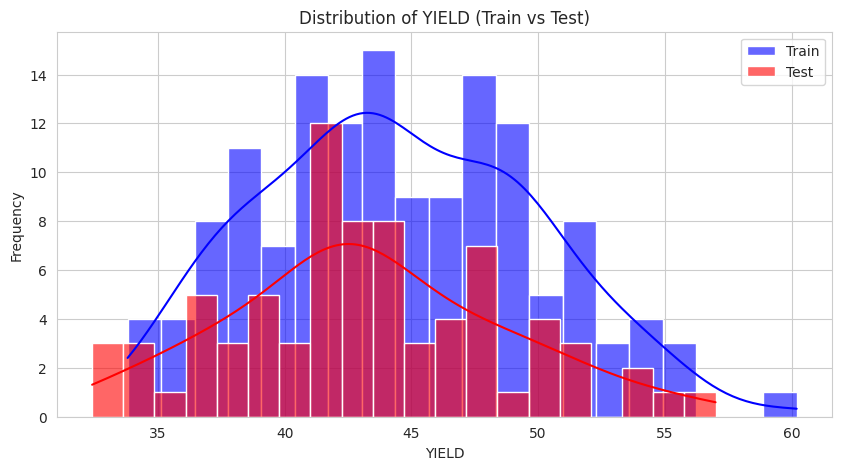

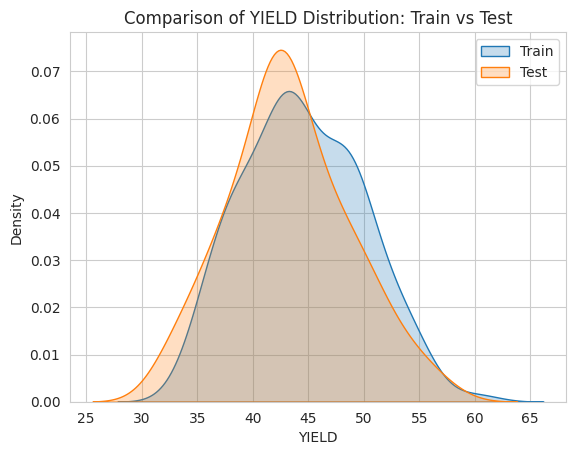

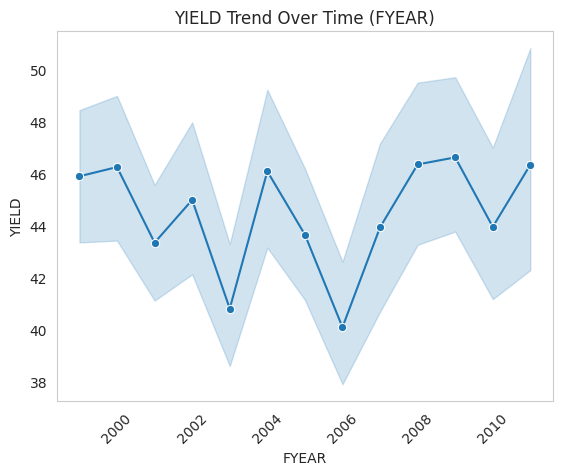

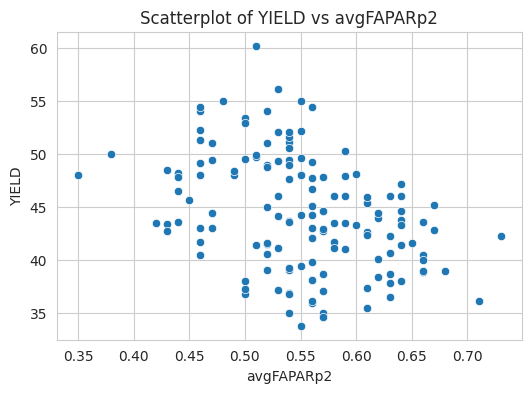

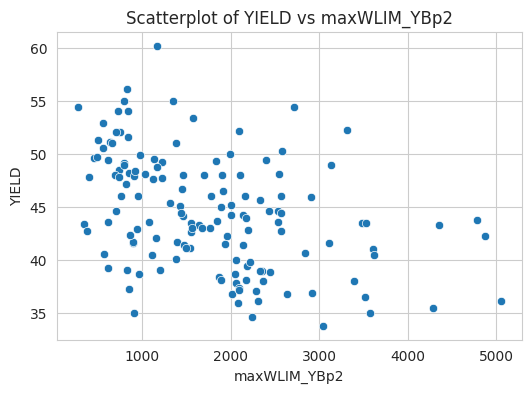

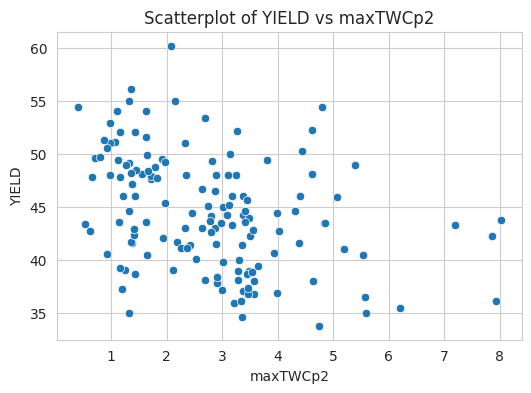

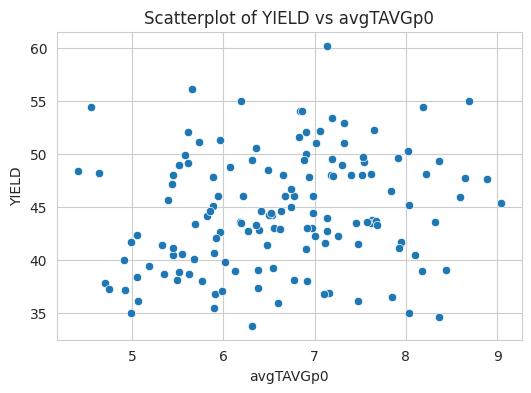

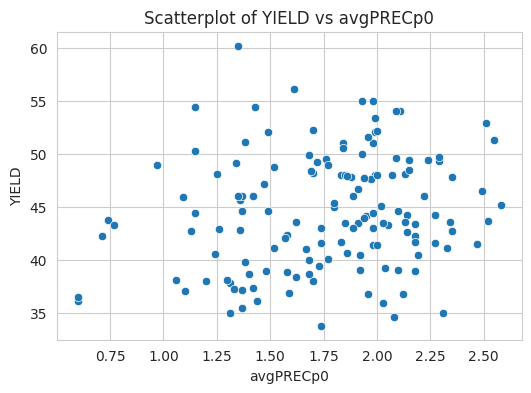

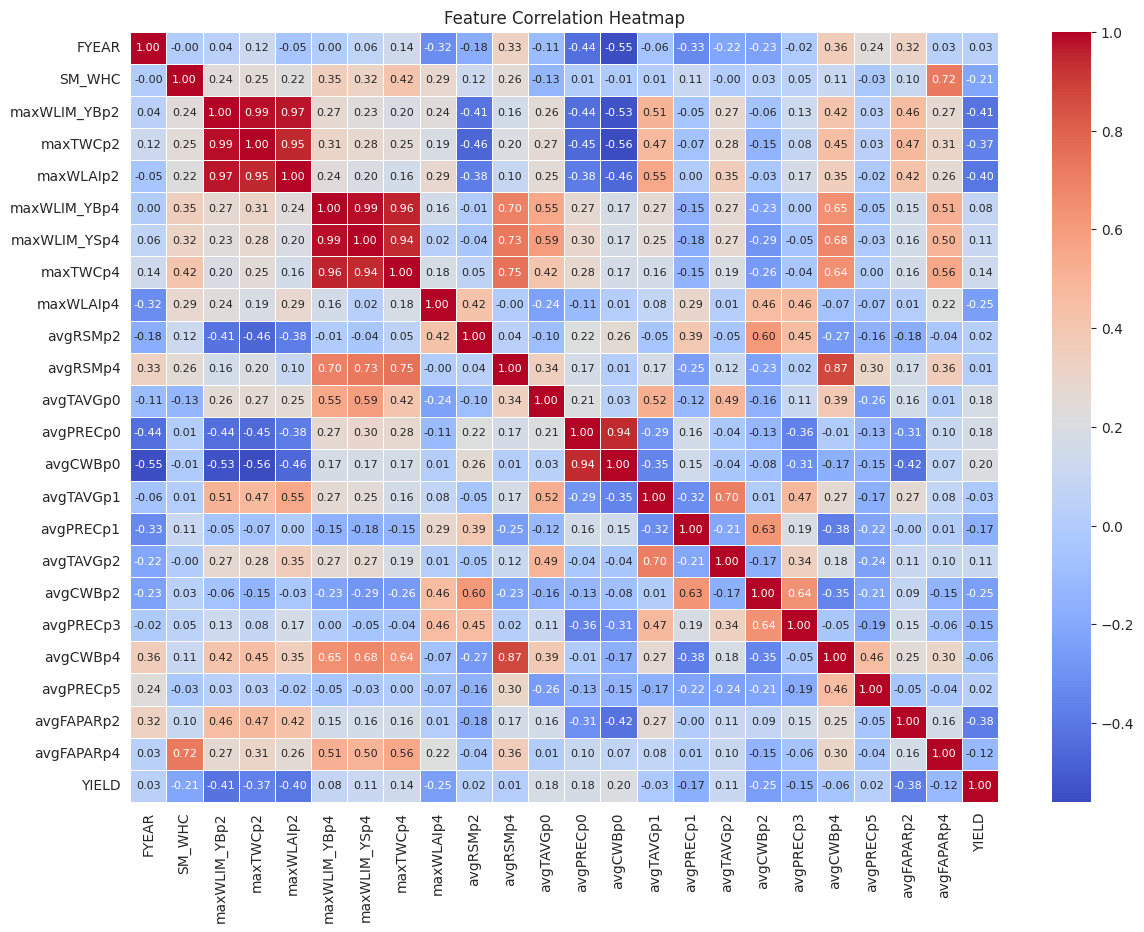

In [ ]:
# implement task 1.1 here
import matplotlib.pyplot as plt
import seaborn as sns
# use either matplotlib or seaborn to plot. Make sure the plots look nice.

# Set visualization style
sns.set_style("whitegrid")

# Histogram of YIELD (Train vs. Test)
plt.figure(figsize=(10, 5))
sns.histplot(train["YIELD"], bins=20, kde=True, color="blue", label="Train", alpha=0.6)
sns.histplot(test["YIELD"], bins=20, kde=True, color="red", label="Test", alpha=0.6)
plt.xlabel("YIELD")
plt.ylabel("Frequency")
plt.title("Distribution of YIELD (Train vs Test)")
plt.legend()
plt.show()

# KDE plot comparison of Yield(train vs test)
sns.kdeplot(train["YIELD"], label="Train", fill=True)
sns.kdeplot(test["YIELD"], label="Test", fill=True)
plt.title("Comparison of YIELD Distribution: Train vs Test")
plt.legend()
plt.show()

# Trend over time for Train data
sns.lineplot(data=train, x="FYEAR", y="YIELD", marker="o")
plt.title("YIELD Trend Over Time (FYEAR)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Relationship between YIELD and other variables
# Selecting a few important numerical features
feature_cols = ["avgFAPARp2", "maxWLIM_YBp2", "maxTWCp2", "avgTAVGp0", "avgPRECp0"]

# Scatterplots to check correlation visually
for col in feature_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=train, x=col, y="YIELD")
    plt.title(f"Scatterplot of YIELD vs {col}")
    plt.show()

# Correlation heatmap for numeric features only
plt.figure(figsize=(14, 10))  # Increase figure size
corr_matrix = train.select_dtypes(include=["number"]).corr()  # Select only numeric columns
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})  # Larger font size for annotations
plt.title("Feature Correlation Heatmap")
plt.show()



# Exercise 2: Training ML models


In this exercise, we will train a linear model and a non-linear model with the yield data, and evaluate it using several metrics. The aim is to create a model that is independent of location and year, rather is uses weather, remote sensing and crop modelling features as predictors.

## Tasks T (implement below)
- T2.1 Use the "validation set approach" to split the training data into train and validation splits (consider the 2 years as validation and remaining as train).
- T2.2 Scale the data using the MinMaxScaler() from the scikit learn library (use the training data to compute the scaling parameters).
- T2.3 Train one linear model and any one non-linear model (ex: random forest, KNN, XGB etc.)
- T2.4 Visualize predictions (on the test set) vs ground truth (for both models).
- T2.5 Define a function called metrics that returns appropriate metrics (more than one), given the predictions and ground truth
- T2.6 Report train, validation and test metrics for both models.
- T2.7 Compare the non-linear model with the linear model by plotting the errors

## Questions Q (reply in text)
- Q2.1 When splitting the data, which years did you consider as train and validation. Why?
- Q2.2 Why do we scale the data? Why do we only compute the scaling parameters on the train data?
- Q2.3 Which metrics did you choose and why?
- Q2.4 Which non-linear model did you choose and why?
- Q2.5 Comment on the comparison of the error plots between the linear and non-linear model.

---
Answers:

Q2.1 We selected the 2010 and 2011 as validation years. These 2 years were chosen because they are the most recent within the years range (1999 to 2011) and we can test the model on the most recent data. The remaining years 1999 to 2009  were used for training and the model can learn from this broad historical context.

Q2.2 We scale the data because some of the features may have larger values, which means that our models(Linear Regression and Random Forest) will consider them more important, even though they might not be. We only compute the scalling parameters on the training data in order to prevent data leakage(ML model learn to work with information that do not exist in real world).

Q2.3 The metrics that we chosen for this task are MSE(Mean Squared Error) RMSE (Root Mean Squared Error) and the R^2(R-Squared) as evaluation metrics for this model. The main reason is that the MSE tell us how far on average the model's prediction are from their true values. The RMSE it has the same procedure with the MSE but it give us an error value in the same units as the target variable [Yield] making it more interpretable. Finally the R^2 which explains how well the model explains the variance in the target variable

Q2.4 We used Random Forest as our Non-Linear Model because it is powerful and flexible, which function well with structured tabular data like crop yield, as it finds patterns and interactions in the dataset.

Q2.5 From the plot it is notable that overall the RandomForest model has a smaller range of residuals compared to the Linear Regression model, which seems to be more accurate. But looking at the plot we can see that the features are better distributed in the LinearRegression prediction. The difference might be because the correlation between the variables and the target feature are relatively low as we saw from the correlation matrix above.



---


In [ ]:
#impoort libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn import model_selection
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.cross_decomposition import PLSRegression, PLSSVD



In [ ]:
# T2.1 Split training data

#Inspect the unique years in the training data
unique_years = train['FYEAR'].unique()
print("Unique years in the training data:", unique_years)

#Split train data into train_data and validation_data
validation_years = [2010, 2011]
validation_data = train[train['FYEAR'].isin(validation_years)]
train_data = train[~train['FYEAR'].isin(validation_years)]

#Define X and y for train_data, validation_data, and test
X_train_data = train_data.drop(columns=["IDREGION", "FYEAR", "YIELD"])
y_train_data = train_data['YIELD']

X_validation_data = validation_data.drop(columns=["IDREGION", "FYEAR", "YIELD"])
y_validation_data = validation_data['YIELD']

X_test = test.drop(columns=["IDREGION", "FYEAR", "YIELD"])
y_test = test['YIELD']

Unique years in the training data: [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011]


In [ ]:
# T2.2 Scale train and test data
scaler = MinMaxScaler()

#sort the train and test dataframes by FYEAR and IDREGION
train = train.sort_values(by=["FYEAR", "IDREGION"])
test = test.sort_values(by=["FYEAR", "IDREGION"])

# Fit scaler on the training features and transform the data
X_train_scaled = scaler.fit_transform(X_train_data)  # Fit and transform on training data
X_validation_scaled = scaler.transform(X_validation_data)  # Only transform the validation data
X_test_scaled = scaler.transform(X_test)  # Only transform the test data

#Check scaled data
print("Scaled training data preview:", X_train_scaled[1,])
print("Scaled validation data preview:", X_validation_scaled[1,])
print("Scaled test data preview:", X_test_scaled[1,0])

Scaled training data preview: [0.66666667 0.70072299 0.67901235 0.79472693 0.94640544 0.87978717
 0.83719647 0.84172662 0.28318447 0.55681317 0.58531317 0.44736842
 0.53731343 0.82131661 0.33453237 0.42735043 0.52261307 0.51582278
 0.70454545 0.42957746 0.90909091 0.55      ]
Scaled validation data preview: [ 0.66666667  1.14949106  1.29276896  0.97928437  0.92271565  0.88290144
  0.95198675  0.71942446  0.20590291  0.82360723  0.61555076 -0.23026316
 -0.27363184  0.63793103  0.26978417  0.47863248  0.48492462  0.58860759
  1.01623377  0.54929577  1.15151515  0.55      ]
Scaled test data preview: 0.6666666666666666


In [ ]:
# T2.3 Linear Regression and Random forest

linear_model = LinearRegression()
non_linear_model = RandomForestRegressor(n_estimators=100, random_state=42)

#Train the linear model
linear_model.fit(X_train_scaled, train_data['YIELD'])

#Train the non-linear model (Random Forest)
non_linear_model.fit(X_train_scaled, train_data['YIELD'])


RandomForestRegressor(random_state=42)

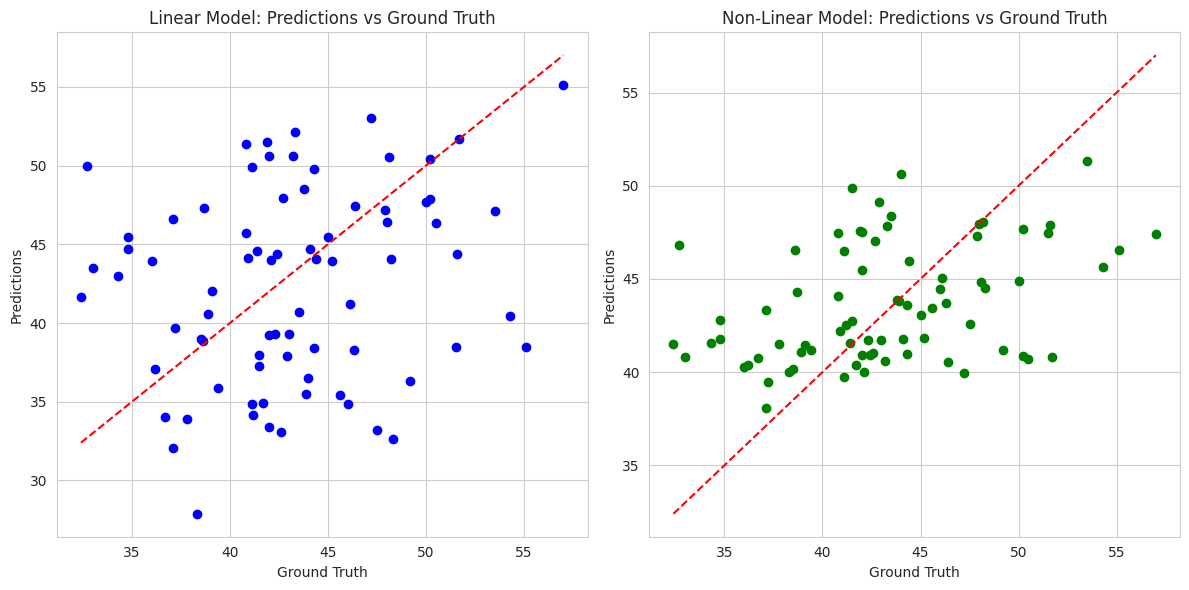

In [ ]:
# T2. 4 Visualize Predictions

linear_preds = linear_model.predict(X_test_scaled)
non_linear_preds = non_linear_model.predict(X_test_scaled)

# Plot Predictions vs Ground Truth
plt.figure(figsize=(12, 6))

# Linear Model
plt.subplot(1, 2, 1)
plt.scatter(y_test, linear_preds, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Linear Model: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")

# Non-Linear Model
plt.subplot(1, 2, 2)
plt.scatter(y_test, non_linear_preds, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Non-Linear Model: Predictions vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")

plt.tight_layout()
plt.show()

In [ ]:
# T2.5: Define a function to calculate metrics
def metrics(gt, pred):
    mse = mean_squared_error(gt, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(gt, pred)
    return {"MSE": mse, "RMSE": rmse, "R2": r2}

# Calculate metrics for both models
linear_metrics = metrics(y_test, linear_preds)
non_linear_metrics = metrics(y_test, non_linear_preds)

# Print metrics
print("Linear Model Metrics:", linear_metrics)
print("Non-Linear Model Metrics:", non_linear_metrics)

Linear Model Metrics: {'MSE': 53.58657117621731, 'RMSE': 7.320284910863601, 'R2': -0.8436937321147251}
Non-Linear Model Metrics: {'MSE': 25.937765935064917, 'RMSE': 5.092913305276746, 'R2': 0.10758804995603133}


In [ ]:
# T2.6: Metrics for train, validation, and test sets
#Train Predictions
train_linear_preds = linear_model.predict(X_train_scaled)
train_non_linear_preds = non_linear_model.predict(X_train_scaled)

# Validation Predictions
validation_linear_preds = linear_model.predict(X_validation_scaled)
validation_non_linear_preds = non_linear_model.predict(X_validation_scaled)

# Test Metrics (already calculated)
test_linear_metrics = metrics(y_test, linear_preds)
test_non_linear_metrics = metrics(y_test, non_linear_preds)

# Calculate and print metrics for each dataset
train_linear_metrics = metrics(train_data['YIELD'], train_linear_preds)
train_non_linear_metrics = metrics(train_data['YIELD'], train_non_linear_preds)

validation_linear_metrics = metrics(validation_data['YIELD'], validation_linear_preds)
validation_non_linear_metrics = metrics(validation_data['YIELD'], validation_non_linear_preds)

# Print metrics
print("Train Metrics (Linear Model):", train_linear_metrics)
print("Train Metrics (Non-Linear Model):", train_non_linear_metrics)
print("Validation Metrics (Linear Model):", validation_linear_metrics)
print("Validation Metrics (Non-Linear Model):", validation_non_linear_metrics)
print("Test Metrics (Linear Model):", test_linear_metrics)
print("Test Metrics (Non-Linear Model):", test_non_linear_metrics)

Train Metrics (Linear Model): {'MSE': 8.756355363865508, 'RMSE': 2.959113949118132, 'R2': 0.6753954223741203}
Train Metrics (Non-Linear Model): {'MSE': 2.000376677685945, 'RMSE': 1.414346731776174, 'R2': 0.9258445552321374}
Validation Metrics (Linear Model): {'MSE': 89.79194740369036, 'RMSE': 9.475861301416899, 'R2': -1.3376867150125968}
Validation Metrics (Non-Linear Model): {'MSE': 32.02980909090912, 'RMSE': 5.6594884124723785, 'R2': 0.16612055578237028}
Test Metrics (Linear Model): {'MSE': 53.58657117621731, 'RMSE': 7.320284910863601, 'R2': -0.8436937321147251}
Test Metrics (Non-Linear Model): {'MSE': 25.937765935064917, 'RMSE': 5.092913305276746, 'R2': 0.10758804995603133}


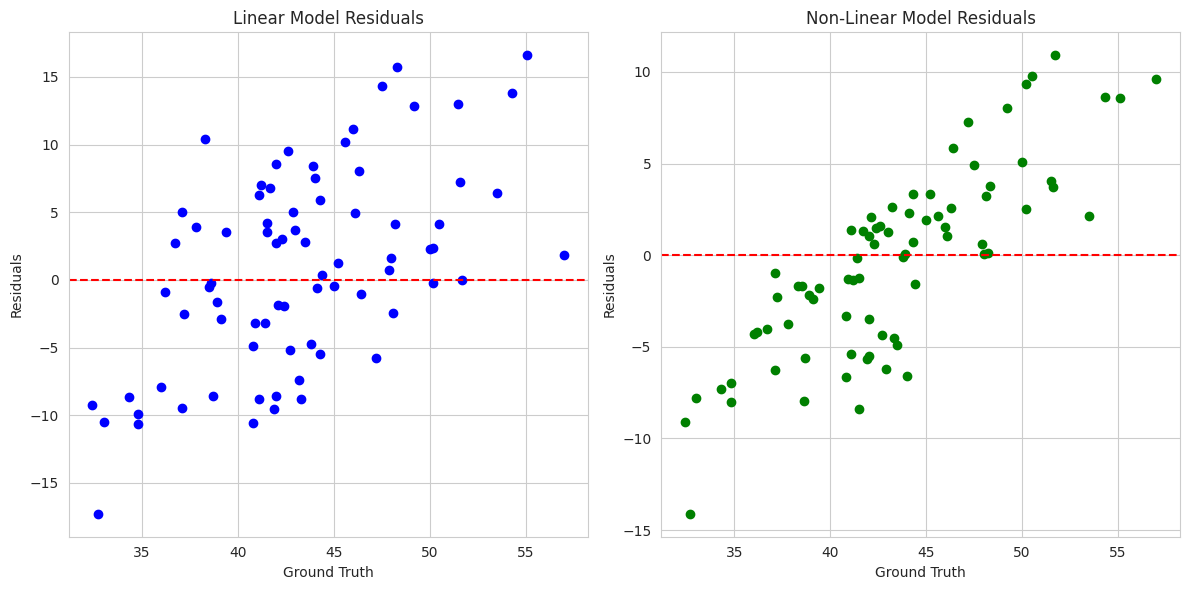

In [ ]:
# T2.7: Calculate residuals (errors)
linear_residuals = y_test - linear_preds
non_linear_residuals = y_test - non_linear_preds

# Plot the residuals
plt.figure(figsize=(12, 6))

# Linear Model Residuals
plt.subplot(1, 2, 1)
plt.scatter(y_test, linear_residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Linear Model Residuals")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

# Non-Linear Model Residuals
plt.subplot(1, 2, 2)
plt.scatter(y_test, non_linear_residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Non-Linear Model Residuals")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

## Exercise 3: Hyperparameter tuning
We will now tune the main (hyper)parameters of the model. This means you will loop the model with different values and retain the one that gives the best performances (cross-validation, chapter 5.1). Select any 2 hyperparameters. We will make use of the validation set to get the best model, and only use the best model to obtain predictions on the test set. **Do not use the test set here to select the best model, otherwise you will bias your final results!**

## Tasks T (implement below)
- T3.1 Use `GridSearchCV` to get the best hyperparameters for your model (once again, only make use of the validation set for all this. DO NOT use the test set)
    - Tips:
        - Remember about scaling the data like before, and ensure that you compute the scaling parameters on the train set only.
        - Consider using the `Pipeline` function from scikit-learn.
        - Consider also using a `TimeSeriesSplit` function from scikit-learn to ensure the splits are done in the way you want it.
        - Make sure that the metric in GridSearchCV is the RMSE.
- T3.2 Print out the best parameters
- T3.3 Report the final test score on the test set using the best parameters you got from Task T3.1.
    - Remember to use the same scaler (only valid if you have multiple scalers defined).
- T3.4 Plot the prediction vs ground truth for the best model

## Questions Q (reply in text)
- Q3.1 Comment on the parameters that need to be adjusted. Why did you choose these, and what do they do in the model?
- Q3.2 How do you choose the range of values
- Q3.3 Why does a good performance on the validation set not reflect a good performance on the test set? (In many cases, you will find that the validation set performance is good, while the test set performance is not the best. Comment on why this could happen).
- Q3.4 Comment on how the plot looks like when comparing the same plot from the previous task (without any hyperparameter search)

---
Answers:

Q3.1 The parameters that we tuned for the RandomForest are the n_estimators which is the number of the trees, the max_depth which is the maximum depth of each tree. As a result to balance the bias-variance  trade - off  and  to improve the computational efficiency.

Q3.2 The range that we chose for n_estimators was [50, 100, 200] and for max_depth was [1, 10, 20]. We chose those numbers based on the computational limitations and overall preformance of the model. For the n_estimators we know that more trees help the model to be more accurate but takes more computation time. We thought that this range was the best to cover every possibility. For the max_depth giving this range cover three different possiblities: 1)Low depth, 2) A more balnce depth and 3)Deep depth.

Q3.3 The model may not perform good in the test set because it might have learned the patterns that only work for the validation data, not for the new data. The validation set might not fully represent  all possible situations in the test set so the model struggles to find new patters.

Q3.4 Comparing both plots from the two exercises we came to the conclusion that no of them is suitable for this kind of application, as they both have an extremely low R^2. Especially, the hyperparameter model of the last exercise has a negative value of R^2 which means that the average value that we get without the model is even better than this random forest with these parameters.

---



In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer




In [ ]:
# T3.1
# Use a pipeline to scale and train the model
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),  # Scaling step
    ("rf", RandomForestRegressor(random_state=42))  # Random Forest Model
])

# Define hyperparameter grid
param_grid = {
    "rf__n_estimators": [50, 100, 200],  # Number of trees
    "rf__max_depth": [1, 10, 20]  # Tree depth
}

# Use TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform Grid Search with RMSE as the evaluation metric
grid_search = GridSearchCV(
    pipeline, param_grid, cv=tscv, scoring=rmse_scorer, n_jobs=-1, verbose=2
)

# Deifne variables
X_train = train.drop(columns=["IDREGION", "FYEAR", "YIELD"])
y_train = train['YIELD']

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 10, 20],
                         'rf__n_estimators': [50, 100, 200]},
             scoring=make_scorer(mean_squared_error, response_method='predict', squared=False),
             verbose=2)

In [ ]:
# T3.2 Print best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'rf__max_depth': 1, 'rf__n_estimators': 50}


In [ ]:
# T3.3
# Extract the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Train the final model using the best hyperparameters
final_model = RandomForestRegressor(
    n_estimators=best_params["rf__n_estimators"],
    max_depth=best_params["rf__max_depth"],
    random_state=42
)

# Fit the model on the entire training set
final_model.fit(X_train, y_train)

# Ensure test data is scaled before predictions
scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit only on training data
X_test = scaler.transform(test[features])
y_test = test["YIELD"]

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# Compute the final test RMSE and R² score
test_rmse = mean_squared_error(y_test, y_pred_test)  # RMSE
test_r2 = r2_score(y_test, y_pred_test)  # R² Score

# Print the final test scores
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Final Test RMSE: 40.5252
Final Test R² Score: -0.3943


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


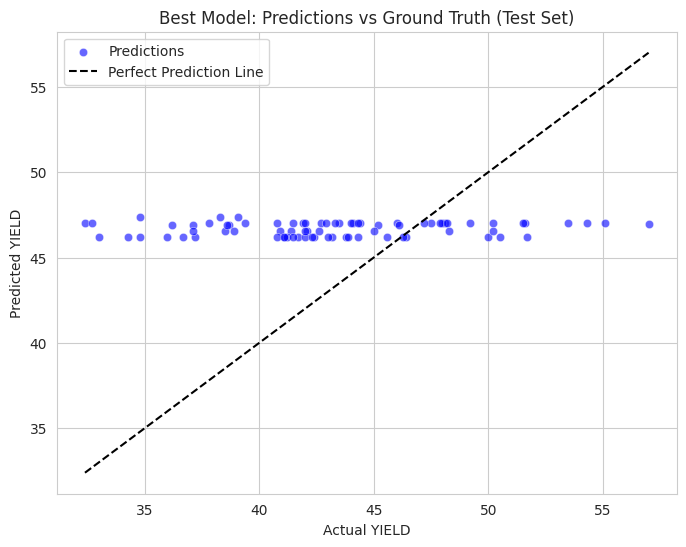

In [ ]:
# T3.4 Plot the prediction vs ground truth for the best model
# Create a scatter plot comparing predicted vs actual YIELD values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, color="blue", alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--", label="Perfect Prediction Line")

# Labels and title
plt.xlabel("Actual YIELD")
plt.ylabel("Predicted YIELD")
plt.title("Best Model: Predictions vs Ground Truth (Test Set)")
plt.legend()
plt.show()

## Exercise 4: Error Visualization

## Tasks T (implement below)
- T4.1 Plot the model error over time and space. Use a suitable plotting method to answer the question below.

## Questions Q (reply in text)
- Q4.1 Comment on the plot.
- Q4.2 Why is your model performing better in some regions and some years, while it is worse in others?
---
Answers:

Q4.1 The line plot(absolute error over time) showcasing that the model works well from 2012 - 2017, however it has a large increase in error in 2018. The lowest error is observed from 2014 until 2017. The box plot(absolute error over space) showcasing that the regions NL12, NL32 and Nl42 have the highest median error(8-10). In addition to that, some regions(Nl21, NL34, NL41) have a large error spread which indicates that there is incosistensy in the preformance of the model.

Q4.2 The model's performance varies depending on the characteristics of each region and years. For some regions the model might have relevant features which makes more accurate predictions resulting in smaller residuals. In other regions, the features might be sparse for example very big range in features in soil, soil humidity etc,etc.  leading to larger residuals. Similarly some years might have unusual trends (temperature) that make predictions harder for the model.

---



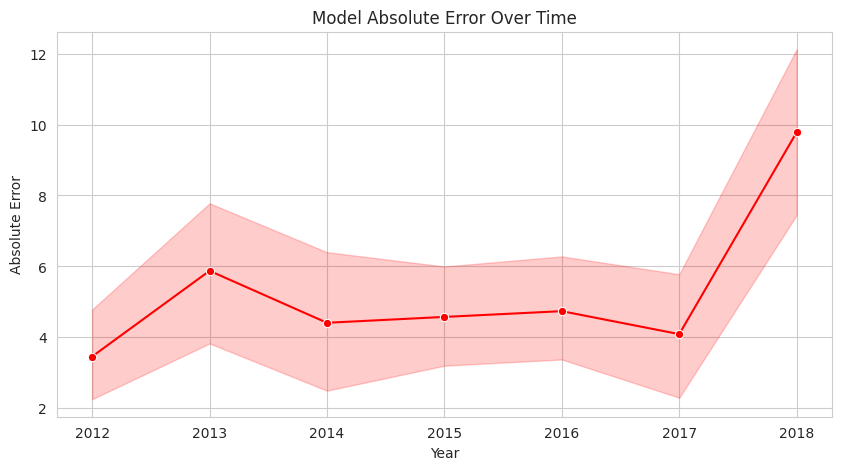

<ipython-input-147-f79299e58633>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="IDREGION", y="Absolute_Error", data=test_errors, palette="coolwarm")


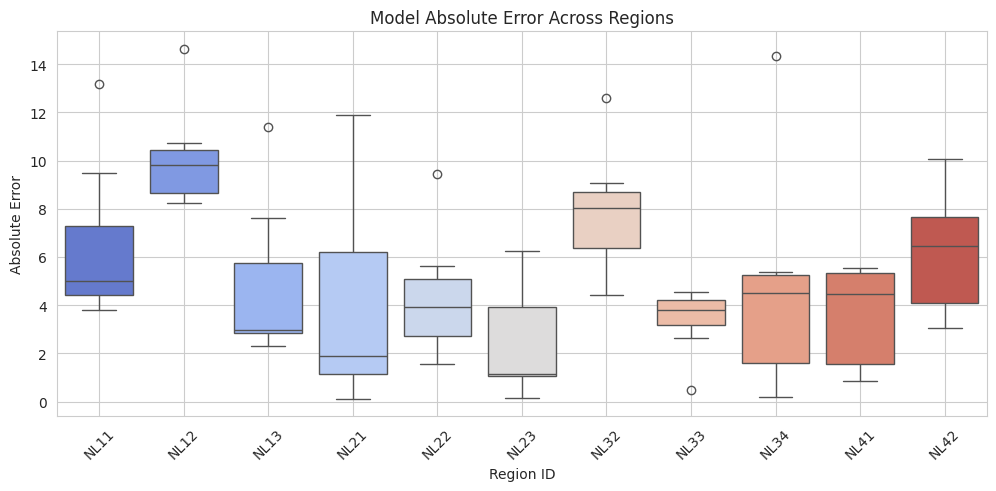

In [ ]:
# Create DataFrame for error analysis
test_errors = pd.DataFrame({
    "FYEAR": test["FYEAR"],  # Year for time-based analysis
    "IDREGION": test["IDREGION"],  # Region for spatial analysis
    "Actual_YIELD": y_test,
    "Predicted_YIELD": y_pred_test,
    "Error": y_test - y_pred_test,  # Residual error
    "Absolute_Error": abs(y_test - y_pred_test)  # Absolute error
})

# 🔹 Plot Error Over Time (Yearly Error Trends)
plt.figure(figsize=(10, 5))
sns.lineplot(x="FYEAR", y="Absolute_Error", data=test_errors, marker="o", color="red")
plt.xlabel("Year")
plt.ylabel("Absolute Error")
plt.title("Model Absolute Error Over Time")
plt.grid(True)
plt.show()

# 🔹 Plot Error Over Space (Regional Errors)
plt.figure(figsize=(12, 5))
sns.boxplot(x="IDREGION", y="Absolute_Error", data=test_errors, palette="coolwarm")
plt.xlabel("Region ID")
plt.ylabel("Absolute Error")
plt.title("Model Absolute Error Across Regions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Well done! See you next week
AI Statement: In this report, artificial intelligence primarily assisted in writing Python code and providing additional insights for the questions posed. It streamlined the implementation of classification models, data processing, and visualization while also offering valuable explanations to enhance understanding.

### References

D. Paudel, H. Boogaard, A. de Wit, S. Janssen, S. Osinga, C. Pylianidis, and I. N. Athanasiadis. [Machine learning for large-scale crop yield forecasting](http://dx.doi.org/10.1016/j.agsy.2020.103016). Agricultural Systems, 187:103016, 2021.